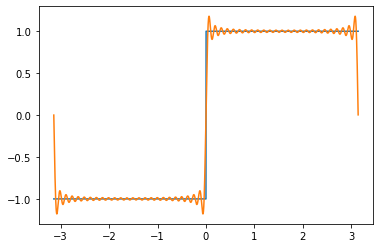

In [1]:
import numpy as np
import matplotlib.pyplot as plt

resolution = 0.0001
x = np.arange(-np.pi, np.pi, resolution)

square = np.zeros_like(x)
squarefft = np.zeros_like(x)

# define a square pulse
square[:int(x.size/2)] = -1
square[int(x.size/2):] = 1


# use fourier series to fit
n = 50
for k in range(1,n+1):
    a = 2/((k)*np.pi)*(1-(-1)**(k))
    squarefft = squarefft + a*np.sin(k*x)
    
plt.plot(x, square, x, squarefft)

dt : 0.001002004008016032 Sampling Frequency : 998.0000000000001


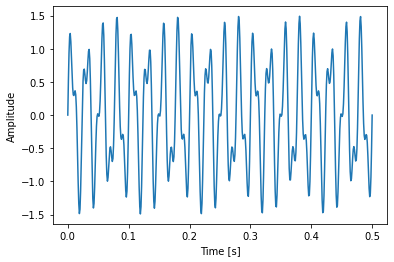

Shape gives N (500,) (500,)
C0 : (4.440892098500626e-14+0j) C1 : (0.0003804834928383405-0.06055503176190069j) C2 : (0.0015317714831365181-0.121888085280696j)


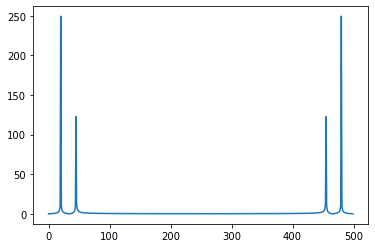

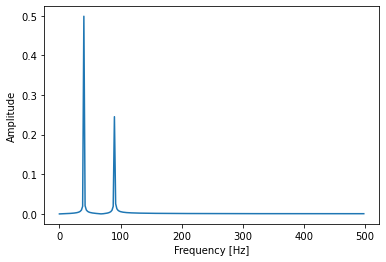

In [11]:
#Discrete Fourier Transform
N = 500
T = .5
t = np.linspace(0, T, N)
dt = t[1]-t[0]
Fs = 1/dt # sampling frequency - usually given

freq = np.linspace(0, 1 / dt, N) # maximum value of frequency is Fs ( = 1/dt)
print("dt :", dt, "Sampling Frequency :", Fs)

# Create a signal with 40Hz and 90Hz frequency
f1,f2 = 40, 90
s = np.sin(f1 * 2 * np.pi * t) + 0.5 * np.sin(f2 * 2 * np.pi * t)

plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
plt.show()


#Fourier transform
f = np.fft.fft(s)
print("Shape gives N", np.shape(s), np.shape(f))
print("C0 :", f[0],"C1 :", f[1], "C2 :",f[2])

# The plot will be symmetric, half of them useless
plt.plot(np.abs(f))
plt.show()

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(freq[:N//2],np.abs(f)[:N//2]*1/N)
# plt.axvline(40, c = 'r');plt.axvline(90, c = 'r')

# Complex Fourier Transform (Discrete Fourier Transform)
- f(t), t = [0, T], T (tau) is maximum time for f(t)
- Data is sampled at 2N + 1 points (from 0 sec to T sec)
- dt = T/2N, t = 0, dt, 2dt, 3dt, ..., 2Ndt (time vectors)
- Lets take time vector as t = t0, t1, t2, ..., t2N
- important quantities : 
    1. dt : defines sampling frequency(defines how fast a sensor can sample) : Fs = 1/dt
    2. 2N + 1 : How long you sample and how fast you sample mixed
- f(t) = Sigma|-N ~ N {Ck*exp[i * 2*pi*fk*t]}, fk = k/T (f(2N) = Fs), k = -N, ..., 0, ..., +N
    - in f(t), everything is known except Ck
    - Ck = 1/2N * Sigma | j = 0 ~ 2N {f(tj) * exp[-i * 2*pi*fk*tj]}
    - f(tj) = Sigma|-N ~ N {Ck * exp[i * 2*pi*fk*tj]}, j = 0, 1, 2, ..., 2N
    - f(t) and Ck are called Fourier Transform Pairs (one is positive i and one is negative i)
    - We want to figure our C(-N), C(-N+1), ..., C(0), ..., C(N)
    - C(m) and C(-m) are complex conjugates. C(m) = C(-m)＊
    - So, we need to define unique Ck = C0, C1, ..., CN, wich corresponds to fk = k/T [Hz]
    - Power Spectrum : Pk = 1/N * |Ck|^2 [J] is also in line with Ck and fk, it tells how much energy there is in the frequency
        - example) T = 1000s, N = 1000, k = 1, f1 = 0.001 Hz, C1 = 1 + 2i - > P1 = 0.001 * |1+2i|^2 = 0.005
    - as C(m) = C(-m)＊, the power spectrum will be symmetric; P(m) = P(-m)

- In Python, C = fft(f) ; if f has 2N+1 points, so will C
- Due to convention, the python will move the plot to all positive sides, but it doesn't matter as only half of the plot is important, the other half will be mirrored version
- So, you might want to just plot 0 ~ N or 0 ~ Fs/2, which is called Nyquist Frequency.
- you will need a sensor that can sample twice the frequency you are intrested in as half is not useful.(Nyquist Theorem)

In [3]:
#Analyzing an audio signal. DFT and Spectrogram
from scipy.io import loadmat
import librosa
import plotly.graph_objects as go
from IPython.display import Audio
import plotly.express 
from audio2numpy import open_audio
from librosa import display


#Loading the signal
fp = "FA18.wav"

signal, sampling_rate = librosa.load(fp, sr = None)
N=len(signal)
duration=len(signal)/sampling_rate
print(duration,"seconds")
print(sampling_rate)
dt=1/sampling_rate
t=np.linspace(0,len(signal)*dt,len(signal))
freq=np.linspace(0,sampling_rate,len(signal))
Audio(fp)




#Plotting the signal and the frequency content

plt.figure()
#librosa.display.waveplot(y=signal,sr=sampling_rate)
plt.plot(t,signal)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

plt.figure()
f=np.fft.fft(signal)
plt.plot(freq[:len(signal)//2],np.abs(f[:len(signal)//2]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()


#Functions for spectrogram
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14, vals_out='abs'):
    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)
    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])
    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    # Compute spectrogram feature
    specgram = 2/N * np.abs(fft)
    z_title = "Amplitude"
    
    return specgram, freqs, z_title

def make_spectrogram(samples, f_samp, z_axis='abs'):
    spectrum, freqs, z_title = spectrogram(samples, f_samp, stride_ms = 10.0, window_ms = 20.0, max_freq = None, eps = 1e-14, vals_out=z_axis)
    fig = go.Figure(data=[go.Surface(z=spectrum, y=freqs, colorscale = 'spectral')])
    fig.update_layout(
                title="3D Spectrogram", title_x=.5    
            )
    fig.update_layout(scene = dict(
                        xaxis_title='Time',
                        yaxis_title='Frequency/Hz',
                        zaxis_title=z_title),
                        width=700,
                        margin=dict(r=20, b=10, l=10, t=10))
    fig.show()


#Creating a spectrogram
make_spectrogram(signal, sampling_rate, z_axis='abs')

/Users/kunwoosmac/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'librosa'

In [ ]:
fp = "/content/whistle_2022-10-30_123631080.wav"
signal, sampling_rate = librosa.load(fp, sr = None)

N=len(signal)
duration=len(signal)/sampling_rate
print(duration,"seconds")
print(sampling_rate)
dt=1/sampling_rate
t=np.linspace(0,len(signal)*dt,len(signal))
freq=np.linspace(0,sampling_rate,len(signal))
Audio(fp)




#Plotting the signal and the frequency content

plt.figure()
# librosa.display.waveplot(y=signal,sr=sampling_rate)
plt.plot(t,signal)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

plt.figure()
f=np.fft.fft(signal)
plt.plot(freq[:len(signal)//2],np.abs(f[:len(signal)//2]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

make_spectrogram(signal, sampling_rate, z_axis='abs')

In [2]:
print(type(2^2))

<class 'int'>
